This is a tutorial on Text Generation using Deep Learning. Text Generation is the art of generating words or sentences which will follow the given input text.
Here, Long Short-term Memory(LSTM) model is used for the purpose which serves a vital role in preserving the context over long period of time.

The scope of this tutorial are as follows:

* Understanding Text Preprocessing
* Understanding Implementation in PyTorch
* Understanding solving NLP problems using Deep Learning
* Understanding the workflow of Sequence Models

Here is a nice tutorial on builiding models uisng PyTorch [Link](https://www.kaggle.com/ankitjha/the-ultimate-pytorch-guide)

This is the abstract architecture of the model

![LSTM](https://cdn-images-1.medium.com/max/1200/1*FCVyju8lPTvfFfxT-rzInA.png)


This tutorial has been divided into following sections:

* Text Preprocessing
* Feature Selection
* Model Training and Evaluation
* Generating Predictions

# Importing Packages

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
!pip install pyspellchecker
import re 
from wordcloud import WordCloud, STOPWORDS
from spellchecker import SpellChecker
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from collections import Counter
%matplotlib inline
import torch.utils.data
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os

    100% |████████████████████████████████| 1.9MB 16.0MB/s ta 0:00:01
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
df = pd.read_csv('../input/Womens Clothing E-Commerce Reviews.csv')
df.dropna(inplace = True)
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits


We will concatenate all the text in the *Review Text* column to form a single string to learn the language model for generating predictions for possible candidates of words

In [3]:
# Function to check presence of a digit in a string
def contains_digit(string):
    return bool(re.search(r'\d', string))

# Text Preprocessing

The Text preprocessing involves following steps:

* Cleaning the text data(Removing extra fullstops and exclamation marks.)
* Removing numbers because these can affect the performance of the model and lead to a larger embedding size.
* Spell correction as review dataset contains many spelling mistakes. There are many spell correcting libraries. However, I have chosen [pyspellchecker](https://pypi.org/project/pyspellchecker/) which implements a simple spell checking algorithm designed by Peter Norvig.
* Converting data into lowercase

In [4]:
class TextPreprocessing:
    def __init__(self, train):
        self.text = ''
        self.cleaned_text = []
        self.input_text = ''
        self.train = train
        
    def gettext(self, df, colname, num_cols):
        if self.train == True:
            #concatenating all the column values to form a single string
            for line in df[colname].values[:num_cols]:
                self.text += line
        else:
            for line in df[colname].values[num_cols:]:
                self.text += line
    
    # Cleaning the text
    def clean_text(self):
        self.text = re.sub("([\(\[]).*?([\)\]])", "", self.text)
        fullstops = ['...', '..', '!!!', '!!', '!']
        for s in fullstops:
            self.text = self.text.replace(s, ".")
    
    # Removing sentences with digits
    def remove_numbers(self):
        for sentence in self.text.split('.'):
            if(contains_digit(sentence) == False):
                self.cleaned_text.append(sentence.rstrip())
        self.input_text = '.'.join(sentence for sentence in self.cleaned_text)
    
    # Spell correction of misspelled words
    def spell_correction(self):
        _spell = SpellChecker()
        incorrect_words = []
        correct_words = []
        # Finding all words in the input text
        res = re.findall(r'\w+', self.input_text) 
        for word in tqdm(set(res)):
            correct = _spell.correction(word)
            if(word != correct):
                incorrect_words.append(word)
                correct_words.append(correct)
        for i, word in enumerate(incorrect_words):
            self.input_text = self.input_text.replace(word, correct_words[i])
        return self.input_text.lower()

In [5]:
text_data = TextPreprocessing(train = True)
text_data.gettext(df, 'Review Text', 100)
text_data.clean_text()
text_data.remove_numbers()
input_text = text_data.spell_correction()
# Here, input text contains the preprocessed text.
train_text = input_text.split()

# Fetching data for validation
valid_text_data = TextPreprocessing(False)
valid_text_data.gettext(df, 'Review Text', -100)
valid_text_data.clean_text()
valid_text_data.remove_numbers()
valid_input_text = valid_text_data.spell_correction()
valid_text = valid_input_text.split()

100%|██████████| 1052/1052 [00:26<00:00, 40.37it/s]


Now, we got the data as a list of words. Here we need to find a representation of these sequence of words to feed into the model.

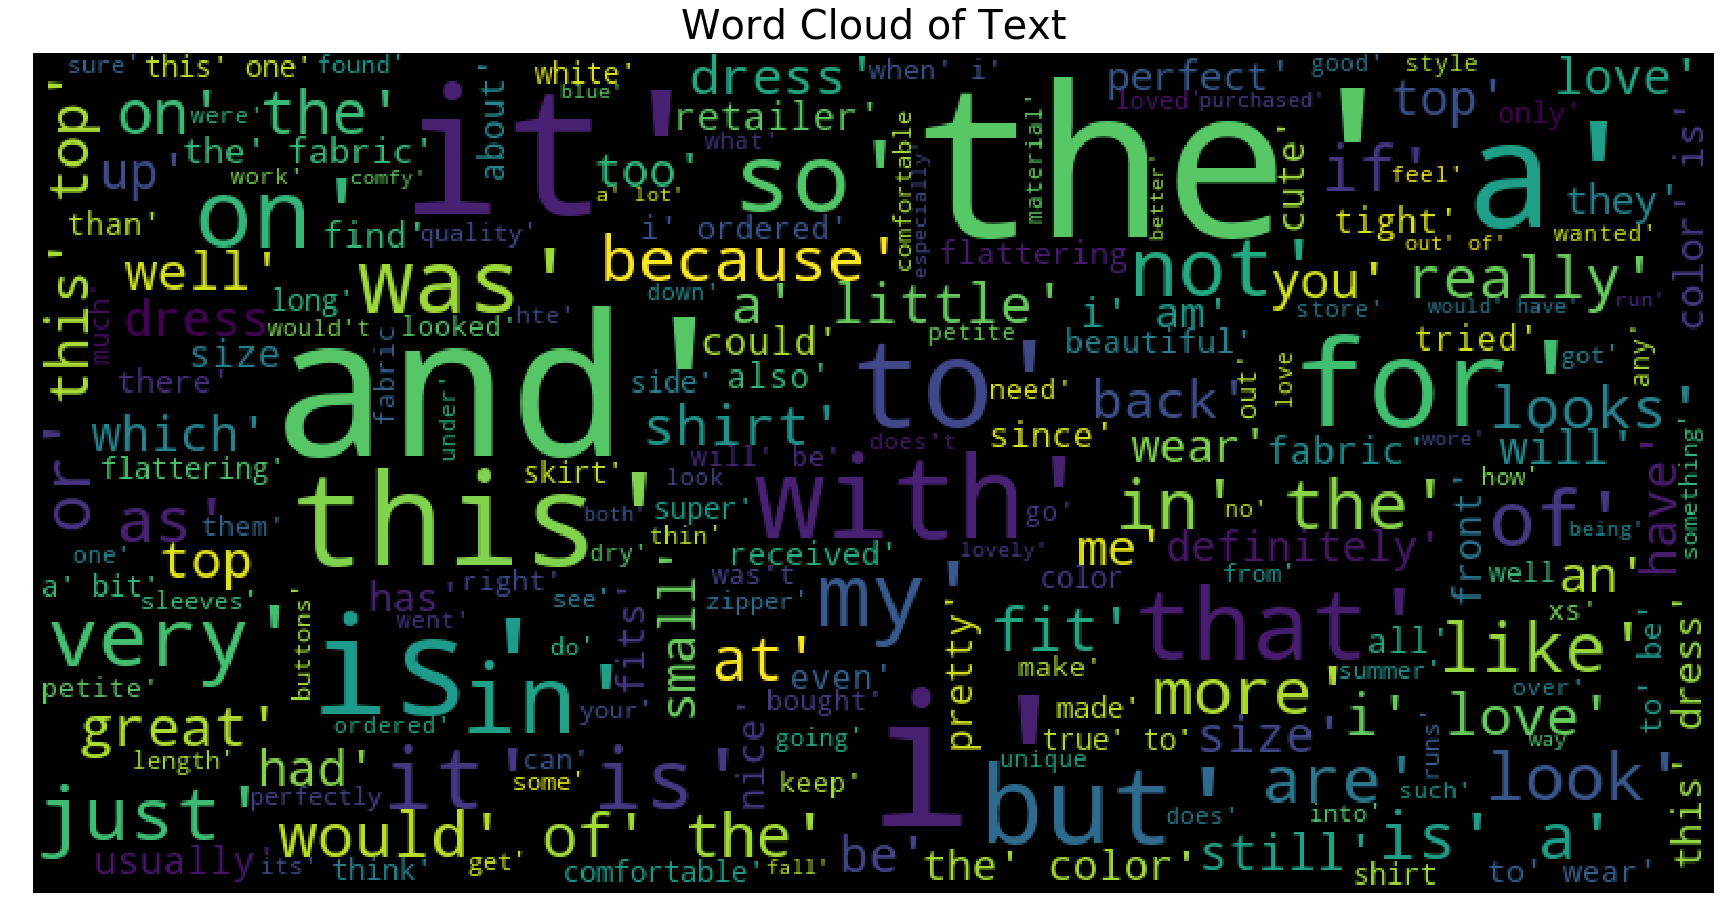

In [6]:
def wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
wordcloud(train_text, title="Word Cloud of Text")

# Feature Selection

Here as a feature represetation of the data, I am generating a representation of each of the word using a unique integer value. For example, this sentence *['I', 'am', 'good', 'and', 'am', 'writing']* can be represented as: *[0, 1, 2, 3, 1, 4]*

In [7]:
words_set = set(train_text).union(set(valid_text))
key_val = {}
val_key = {}
for i, key in enumerate(words_set):
    key_val[key] = i
    val_key[i] = key

In [8]:
{k: key_val[k] for k in list(key_val)[:5]}

{'throughout': 0, 'overall.': 1, 'it.i': 2, 'tailor': 3, 'no.': 4}

In [9]:
{k: val_key[k] for k in list(val_key)[:5]}

{0: 'throughout', 1: 'overall.', 2: 'it.i', 3: 'tailor', 4: 'no.'}

In [10]:
batch_size = 16
num_timesteps = 32
train_arr = []
valid_arr = []
train_loss = []
valid_loss = []
num_epochs = 10
num_batches = int(len(train_text) / (batch_size * num_timesteps))
valid_num_batches = int(len(valid_text) / (batch_size * num_timesteps))

# Size of embedding
embedding_size = 64

# Number of units in LSTM Layer
num_lstm_units = 64

# Using cuda if present else cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading in PyTorch

In [11]:
for word in train_text:
    train_arr.append(key_val[word])
    
# Reshaping data to pass into model
train_data = np.reshape(train_arr[:num_batches * batch_size * num_timesteps], (num_batches * batch_size, -1)) 
target = np.reshape(np.append(train_data[1:], train_data[0]), (num_batches * batch_size, -1))
for word in valid_text:
    valid_arr.append(key_val[word])
validation_features = np.reshape(valid_arr[:valid_num_batches * batch_size * num_timesteps], (valid_num_batches * batch_size, -1))
validation_target = np.reshape(np.append(validation_features[1:], validation_features[0]), (valid_num_batches * batch_size, -1))

Let us have a look at how the train features look

In [12]:
# train_data -> shape: num_entries * num_timesteps
train_data.shape

(160, 32)

In [13]:
print(train_data[:5])

[[ 681 1532  712  395 1509 2142 1328 1845  595 1301 1334  134  773  393
  2142 1198  681 1742 1429  735 1227 1728  639  681  708 1328  773  733
   566  475 2162 1728]
 [1025 1396 1660  681  853 1341  297  134 2128  681 1923  134 1025 1227
  1420 1311 2080  246 2022  521  735 1771 1126 2080  857  595  380  415
   639  735 1465 1126]
 [1532  167 2001 1841  335  520  595  526 1713 1434 1971 2019  925  167
  1155  362 1587 2080  735 1371 1971  520 1474 2178  484  735 1238  360
   134  197  962  962]
 [2061 1328 1997  855  979 1413  595  152 1794 1606  681  102 1393  681
  2180 1737  639  871 1469  383  378 2001 1307  773 1247 1569  773  735
   315 2003 1942  134]
 [ 378  735 1161  618  773  102  280 1294  595  134  378 1067 2162  134
  1766 1425  280 2149  914 2061 1328  557 2061 1733 1854 1947  639 1328
   677  378 1341 2142]]


In [14]:
print(target[:5])

[[1025 1396 1660  681  853 1341  297  134 2128  681 1923  134 1025 1227
  1420 1311 2080  246 2022  521  735 1771 1126 2080  857  595  380  415
   639  735 1465 1126]
 [1532  167 2001 1841  335  520  595  526 1713 1434 1971 2019  925  167
  1155  362 1587 2080  735 1371 1971  520 1474 2178  484  735 1238  360
   134  197  962  962]
 [2061 1328 1997  855  979 1413  595  152 1794 1606  681  102 1393  681
  2180 1737  639  871 1469  383  378 2001 1307  773 1247 1569  773  735
   315 2003 1942  134]
 [ 378  735 1161  618  773  102  280 1294  595  134  378 1067 2162  134
  1766 1425  280 2149  914 2061 1328  557 2061 1733 1854 1947  639 1328
   677  378 1341 2142]
 [ 735 2001  462 1328 1845 2080 2001 1505  528  427  735  917  639 1285
   167 1976  427  844  735 1684  378  353  595 2001  465 2162  134 1184
   473 1728 1038 1341]]


While loading the data, these point should be closely worked upon:

* Setting a batch Size
* Shuffling the data
* Parallelizing the tasks using multiprocecssing workers. 

The DataLoader function provides all of these features and you can specify them before heading to next task

In [15]:
#converting numpy array into torch tensor
train = torch.from_numpy(train_data)
targets = torch.from_numpy(target) 

validation = torch.from_numpy(validation_features)
validation_target = torch.from_numpy(validation_target) 

train_set = torch.utils.data.TensorDataset(train,targets)
valid_set = torch.utils.data.TensorDataset(validation, validation_target)


#Loading data into Dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = False, num_workers = 4)
validation_loader = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle = False, num_workers = 4)

# Model Selection

Here, the feature vectors are passed through an LSTM layer followed by a dense layer. I have chosen a simple model just as a starter to check the performance.
LSTM is composed of input gate, cell, output gate and forget gate. These are responsible for regulating flow of information across timesteps.
An indepth tutorial on LSTM is explained [here](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
![LSTM](https://cdn-images-1.medium.com/max/1600/1*Niu_c_FhGtLuHjrStkB_4Q.png)

In [16]:
class Model(nn.Module):
    def __init__(self, num_words, num_timesteps, num_lstm_units, embedding_size):
        super(Model, self).__init__()
        self.num_timesteps = num_timesteps
        self.num_lstm_units = num_lstm_units
        self.embedding = nn.Embedding(num_words, embedding_size)
        self.lstm = nn.LSTM(embedding_size, num_lstm_units, num_layers = 1, batch_first=True)
        self.dense = nn.Linear(num_lstm_units, num_words)
        
    def forward(self, x, hidden_unit):
        embeddings = self.embedding(x)
        prediction, state = self.lstm(embeddings, hidden_unit)
        logits = self.dense(prediction)
        return logits, state

In [17]:
model = Model(len(words_set), num_timesteps,
              embedding_size, num_lstm_units)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

![LSTM](https://cdn-images-1.medium.com/max/1200/1*FCVyju8lPTvfFfxT-rzInA.png)

As described in the image, the feature vector of a word are passed into the LSTM which generates the output corresponding to the next word of the sentence. For example:
In the following sentence
</br>
**I am going there**

The *input* and **output** will be:

* *FV(I)* -> **FV(am)**
* *FV(am)* -> **FV(going)**
* *FV(going)* -> **FV(there)**

where FV stands for Feature Vector

In [18]:
# Function to train the model

def train(epoch):
    #####################
    #  Train the model  #
    #####################
    model.train()
    tr_loss = 0
    # initializing hidden state and cell state with zeros
    h_t, c_t = torch.zeros(1, batch_size, num_lstm_units), torch.zeros(1, batch_size, num_lstm_units)
    h_t.zero_()
    c_t.zero_()
    h_t, c_t = h_t.to(device), c_t.to(device)
    for batch_idx, (X_train, y) in enumerate(train_loader):
        X_train, y = Variable(X_train), Variable(y)
        if torch.cuda.is_available():
            X_train = X_train.to(device)
            y = y.to(device)
            
        # clearning the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward propogation: computing the outputs predicted by the model
        logits, (h_t, c_t) = model(X_train, (h_t, c_t))
        # calculating the loss
        loss = criterion(logits.transpose(1, 2), y)
        h_t = h_t.detach()
        c_t = c_t.detach()
        # backpropogation: computing loss with respect to model parameters
        loss.backward()
        # performing a single step of optimization
        optimizer.step()
        tr_loss += loss.item()
    train_loss.append(tr_loss / len(train_loader))
    print('Train Epoch: {} \tTrain Loss: {:.6f}'.format(epoch, (tr_loss / len(train_loader))))

In [19]:
# Function to validate the model

def evaluate(data_loader):
    ################################
    #    Evaluating the Model      #
    ################################
    model.eval()
    h_t, c_t = torch.zeros(1, batch_size, num_lstm_units), torch.zeros(1, batch_size, num_lstm_units)
    h_t.zero_()
    c_t.zero_()
    h_t, c_t = h_t.to(device), c_t.to(device)
    loss = 0
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.to(device)
            target = target.to(device)
        logits, (h_t, c_t) = model(data, (h_t, c_t))
        loss += criterion(logits.transpose(1, 2), target).item()
        
    loss /= len(data_loader.dataset)
    valid_loss.append(loss)    
    print('Train Epoch: {} \tValidation Loss: {:.6f}'.format(epoch, loss / len(data_loader)))

 # Model Training

In [20]:
n_epochs = 10
for epoch in range(n_epochs):
    #train the model
    train(epoch)
    #evaluate the model
    evaluate(validation_loader)

Train Epoch: 0 	Train Loss: 7.689867
Train Epoch: 0 	Validation Loss: 0.048022
Train Epoch: 1 	Train Loss: 7.682623
Train Epoch: 1 	Validation Loss: 0.047978
Train Epoch: 2 	Train Loss: 7.675379
Train Epoch: 2 	Validation Loss: 0.047934
Train Epoch: 3 	Train Loss: 7.668126
Train Epoch: 3 	Validation Loss: 0.047891
Train Epoch: 4 	Train Loss: 7.660856
Train Epoch: 4 	Validation Loss: 0.047846


In [24]:
def plot_graphs(train_loss, valid_loss, epochs):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,4))
    ax = fig.add_subplot(1, 2, 1)
    plt.title("Train Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('train_loss', fontsize=12)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='best')
    ax = fig.add_subplot(1, 2, 2)
    plt.title("Validation Loss")
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='test')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('vaidation _loss', fontsize=12)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='best')

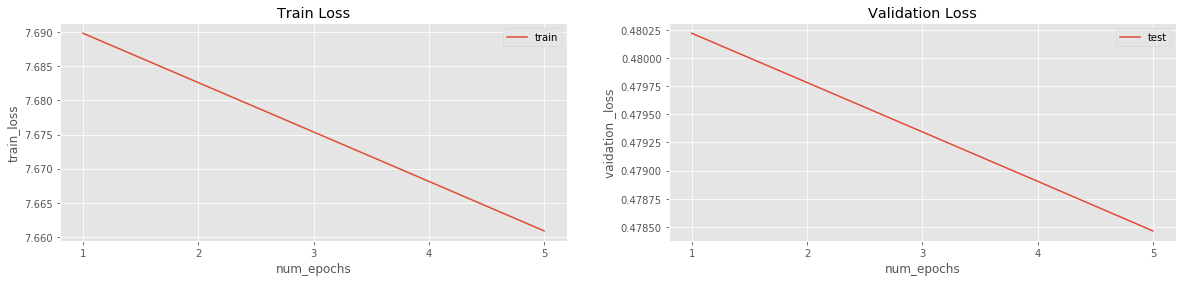

In [25]:
# plotting train and validation loss
plot_graphs(train_loss, valid_loss, n_epochs)

In [26]:
model.eval()
h_t, c_t = torch.zeros(1, batch_size, num_lstm_units), torch.zeros(1, batch_size, num_lstm_units)
h_t.zero_()
c_t.zero_()
h_t, c_t = h_t.to(device), c_t.to(device) 
words = []
final_predictions = []
#count = 0
##################################################
# Generating predictions for next two timesteps  #
##################################################
for i, (word, target_variable) in enumerate(validation_loader):
 #   if(count == 3):
 #       break
    word = word.to(device)
    numpy_word = word.cpu().numpy()
    output, (h_t, c_t) = model(word, (h_t, c_t))
    words = numpy_word.ravel()
    predictions = torch.topk(output[0], k=3)[1].tolist()
    print('**********************************************************************************')
    input_string = []
    for word in words[-25:-15]:
        input_string.append(val_key[word])
    s = ' '.join(input_string)
    print('The input string is:\t {}'.format(s))
    string = []
    string.append(val_key[predictions[0][0]])
    string.append(val_key[predictions[0][1]])
    string.append(val_key[predictions[0][2]])
    print('\nTop 3 predictions Timestep i + 1 for the input string are are {}\n'.format(string))
    print('**********************************************************************************')

**********************************************************************************
The input string is:	 you wear it is just magical. i love this dress.everything

Top 3 predictions Timestep i + 1 for the input string are are ['fitting', 'along', 'drop']

**********************************************************************************
**********************************************************************************
The input string is:	 is girl-next-door sweet. i'm mad about plaid so it was

Top 3 predictions Timestep i + 1 for the input string are are ['difficult.', 'the', 'dress.lots']

**********************************************************************************
**********************************************************************************
The input string is:	 the neck was so big and bulky i had trouble

Top 3 predictions Timestep i + 1 for the input string are are ['the', 'happily', 'support']

***************************************************************************